In [ ]:
print('hello world!')

In [23]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("GCP Dataproc Parquet Reader").getOrCreate()

# Read each dataset into a separate DataFrame
commits_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")
contents_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/contents")
files_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/files")
languages_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")
licenses_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/licenses")

In [24]:
# Inspect schemas
commits_df.printSchema()
contents_df.printSchema()
files_df.printSchema()
languages_df.printSchema()
licenses_df.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

In [ ]:
# Determine the size (number of rows and columns) of each DataFrame
print("Size of commits DataFrame:")
print(f"Rows: {commits_df.count()}, Columns: {len(commits_df.columns)}")

print("\nSize of contents DataFrame:")
print(f"Rows: {contents_df.count()}, Columns: {len(contents_df.columns)}")

print("\nSize of files DataFrame:")
print(f"Rows: {files_df.count()}, Columns: {len(files_df.columns)}")

print("\nSize of languages DataFrame:")
print(f"Rows: {languages_df.count()}, Columns: {len(languages_df.columns)}")

print("\nSize of licenses DataFrame:")
print(f"Rows: {licenses_df.count()}, Columns: {len(licenses_df.columns)}")


# Q1 Discard irrelevant or obviously erroneous data

In [25]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!
import pyspark.sql.functions as F

# Select relevant fields and explicitly alias the nested field
commits_cleaned = commits_df.select(
    "commit",
    "tree",
    "author.name",
    "author.email",
    "author.time_sec",
    F.col("author.date.seconds").alias("author_date_seconds"),  # Alias the nested field
    "subject",
    "message",
    "repo_name"
).filter(
    (F.col("commit").isNotNull()) &
    (F.col("author.name").isNotNull()) &
    (F.col("repo_name").isNotNull())
)

# Add a formatted date column
commits_cleaned = commits_cleaned.withColumn(
    "author_date",
    F.from_unixtime(F.col("author_date_seconds"))
)


commits_cleaned = commits_cleaned.withColumn("author_date", F.to_date("author_date"))

# Show the cleaned DataFrame
commits_cleaned.show(5)


# ==============================================================================================
contents_cleaned = contents_df.select(
    "id",
    "size",
    "content",
    "binary"
).filter(
    (contents_df["id"].isNotNull()) &
    (contents_df["size"] > 0)
)

contents_cleaned.show(5)


# ==============================================================================================
files_cleaned = files_df.select(
    "repo_name",
    "path",
    "mode",
    "id"
).filter(
    (files_df["repo_name"].isNotNull()) &
    (files_df["path"].isNotNull())
)

files_cleaned.show(5)


# ==============================================================================================
from pyspark.sql.functions import explode

languages_cleaned = languages_df.select(
    "repo_name",
    explode("language").alias("language")
).select(
    "repo_name",
    "language.name",
    "language.bytes"
).filter(
    (languages_df["repo_name"].isNotNull()) &
    (languages_df["language"].isNotNull())
)

languages_cleaned.show(5)


# ==============================================================================================
licenses_cleaned = licenses_df.select(
    "repo_name",
    "license"
).filter(
    licenses_df["license"].isNotNull()
)

licenses_cleaned.show(5)




+--------------------+--------------------+--------------------+--------------------+----------+-------------------+--------------------+--------------------+--------------------+-----------+
|              commit|                tree|                name|               email|  time_sec|author_date_seconds|             subject|             message|           repo_name|author_date|
+--------------------+--------------------+--------------------+--------------------+----------+-------------------+--------------------+--------------------+--------------------+-----------+
|aa358905a1b12c6fa...|df3f8bf61bf1cb0df...|conda-forge-coord...|e5ec32c8593b6ea32...|1647357073|         1647357073|Updated the qceng...|Updated the qceng...|[conda-forge/feed...| 2022-03-15|
|5a6b6d6d29489f858...|ff89accb7e283ca88...|           Rob Allen|7e09c9d3e96378bf5...|1323443117|         1323443117|Merge remote-trac...|Merge remote-trac...|[MadCat34/zend-es...| 2011-12-09|
|6b6ac3b8ab7363b22...|915acc1689313e3e2.

+--------------------+-----+--------------------+------+
|                  id| size|             content|binary|
+--------------------+-----+--------------------+------+
|d5b1049fdaa182fa5...| 1570|{"version":3,"sou...| false|
|896830f9ea31efd6b...|18616|                null|  true|
|bf1e2a8490344601c...|15580|                null|  true|
|e5976431eba91aa73...| 3328|                null|  true|
|311532e41682cab22...| 8970|                null|  true|
+--------------------+-----+--------------------+------+
only showing top 5 rows



+--------------------+--------------------+-----+--------------------+
|           repo_name|                path| mode|                  id|
+--------------------+--------------------+-----+--------------------+
|    enzbang/diouzhtu|gwiad_wiki_servic...|33261|49365044eed287691...|
|TheMrNomis/Latex-...|             LFM.php|33261|ef8cb78feed7f2111...|
|TheMrNomis/Latex-...|PHP/LatexFlavored...|33261|d989ce59652f57efa...|
|    xurigan/uexJPush|EUExJPush/EUExJPu...|33261|85268b90caa19efa2...|
|    xurigan/uexJPush|EUExJPush/uexJPus...|33261|e1623bb9d8dc7db60...|
+--------------------+--------------------+-----+--------------------+
only showing top 5 rows



+-------------------+----+-----+
|          repo_name|name|bytes|
+-------------------+----+-----+
|  lemi136/puntovent|   C|   80|
|     taxigps/nctool|   C| 4461|
|        ahy1/strbuf|   C| 5573|
|nleiten/mod_rpaf-ng|   C|30330|
|kmcallister/alameda|   C|17077|
+-------------------+----+-----+
only showing top 5 rows



+--------------------+------------+
|           repo_name|     license|
+--------------------+------------+
|autarch/Dist-Zill...|artistic-2.0|
|thundergnat/Prime...|artistic-2.0|
|kusha-b-k/Turabia...|artistic-2.0|
|onlinepremiumoutl...|artistic-2.0|
|huangyuanlove/Lia...|artistic-2.0|
+--------------------+------------+
only showing top 5 rows



# Q2 Complete thorough EDA to identify which variables you can use to complete your analysis

In [26]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!
commits_cleaned = commits_cleaned.drop("tz_offset", "time_sec", "author_date_second")
#commits_cleaned.show()

In [ ]:
commits_cleaned.printSchema()
contents_cleaned.printSchema()
files_cleaned.printSchema()
languages_cleaned.printSchema()
licenses_cleaned.printSchema()

In [ ]:
from pyspark.sql.functions import col, count, avg, max, min

# EDA for commits_cleaned
def analyze_commits(commits_cleaned):
    print("\n=== Commits Data Analysis ===")
    commits_cleaned.select("name", "email", "author_date", "subject").show(5, truncate=False)
    commits_cleaned.groupBy("name").agg(
        count("commit").alias("commit_count"),
        count("repo_name").alias("repo_count"),
    ).orderBy(col("commit_count").desc()).show(5, truncate=False)
    commits_cleaned.describe(["author_date_seconds"]).show()
    commits_cleaned.groupBy("author_date").count().orderBy(col("count").desc()).show(5)

# EDA for contents_cleaned
def analyze_contents(contents_cleaned):
    print("\n=== Contents Data Analysis ===")
    contents_cleaned.select("id", "size", "binary").show(5, truncate=False)
    contents_cleaned.groupBy("binary").agg(
        count("id").alias("binary_count"),
        avg("size").alias("avg_size")
    ).show()
    contents_cleaned.select(max("size").alias("max_size"), min("size").alias("min_size")).show()

# EDA for files_cleaned
def analyze_files(files_cleaned):
    print("\n=== Files Data Analysis ===")
    files_cleaned.groupBy("repo_name").agg(
        count("path").alias("file_count"),
        count("id").alias("unique_file_ids")
    ).orderBy(col("file_count").desc()).show(5, truncate=False)
    files_cleaned.groupBy("mode").count().orderBy(col("count").desc()).show()

# EDA for languages_cleaned
def analyze_languages(languages_cleaned):
    print("\n=== Languages Data Analysis ===")
    languages_cleaned.groupBy("name").agg(
        count("repo_name").alias("repo_count"),
        avg("bytes").alias("avg_bytes"),
        max("bytes").alias("max_bytes"),
        min("bytes").alias("min_bytes")
    ).orderBy(col("repo_count").desc()).show(5, truncate=False)
    languages_cleaned.agg(
        count("repo_name").alias("total_repos"),
        count("name").alias("total_languages")
    ).show()

# EDA for licenses_cleaned
def analyze_licenses(licenses_cleaned):
    print("\n=== Licenses Data Analysis ===")
    licenses_cleaned.groupBy("license").count().orderBy(col("count").desc()).show(5, truncate=False)
    licenses_cleaned.agg(
        count("repo_name").alias("total_repos"),
        count("license").alias("total_licenses")
    ).show()

# Execute analyses
analyze_commits(commits_cleaned)
analyze_contents(contents_cleaned)
analyze_files(files_cleaned)
analyze_languages(languages_cleaned)
analyze_licenses(licenses_cleaned)


# Q3 What is the timeline of the data?  Do you see significant peaks and valleys?
### Necessary to run (get commits_cleaned_filtered) for following steps

In [13]:
timeline_df = commits_cleaned.select(F.min("author_date").alias("start_date"), F.max("author_date").alias("end_date"))
timeline_df.show()

+----------+----------+
|start_date|  end_date|
+----------+----------+
|1970-01-01|2245-02-21|
+----------+----------+



In [27]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!

start_date = "2007-10-19"
end_date = "2023-12-31"

# Filter rows with author_date within the range
commits_cleaned_filtered = commits_cleaned.filter(
    (F.col("author_date") >= start_date) &
    (F.col("author_date") <= end_date)
)

In [10]:
#What is the timeline of the data?  Do you see significant peaks and valleys
commits_cleaned_filtered.select("author_date").show(5)

+-----------+
|author_date|
+-----------+
| 2022-03-15|
| 2011-12-09|
| 2011-04-27|
| 2022-01-26|
| 2014-03-06|
+-----------+
only showing top 5 rows



In [15]:
timeline_agg = commits_cleaned_filtered.groupBy("author_date").count().orderBy("author_date")

In [11]:
# Aggregate commits by day
timeline_agg = commits_cleaned_filtered.groupBy("author_date").count().orderBy("author_date")
timeline_agg.show()

+-----------+-----+
|author_date|count|
+-----------+-----+
| 2007-10-19| 9377|
| 2007-10-20| 5812|
| 2007-10-21| 6288|
| 2007-10-22| 9604|
| 2007-10-23| 9773|
| 2007-10-24| 9540|
| 2007-10-25| 9098|
| 2007-10-26| 9163|
| 2007-10-27| 5936|
| 2007-10-28| 6040|
| 2007-10-29| 9393|
| 2007-10-30| 9908|
| 2007-10-31| 9847|
| 2007-11-01| 9638|
| 2007-11-02| 9452|
| 2007-11-03| 5882|
| 2007-11-04| 6617|
| 2007-11-05| 9555|
| 2007-11-06|10111|
| 2007-11-07| 9435|
+-----------+-----+
only showing top 20 rows



In [16]:
timeline_agg.printSchema()

root
 |-- author_date: date (nullable = true)
 |-- count: long (nullable = false)



In [17]:
from pyspark.sql import functions as F

# Calculate Q1, Q3, and IQR
quantiles = timeline_agg.approxQuantile("count", [0.25, 0.75], 0.05)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows within bounds
filtered_timeline_agg = timeline_agg.filter(
    (F.col("count") >= lower_bound) & (F.col("count") <= upper_bound)
)

# Show the filtered DataFrame
filtered_timeline_agg.show()


+-----------+-----+
|author_date|count|
+-----------+-----+
| 2007-10-19| 9377|
| 2007-10-20| 5812|
| 2007-10-21| 6288|
| 2007-10-22| 9604|
| 2007-10-23| 9773|
| 2007-10-24| 9540|
| 2007-10-25| 9098|
| 2007-10-26| 9163|
| 2007-10-27| 5936|
| 2007-10-28| 6040|
| 2007-10-29| 9393|
| 2007-10-30| 9908|
| 2007-10-31| 9847|
| 2007-11-01| 9638|
| 2007-11-02| 9452|
| 2007-11-03| 5882|
| 2007-11-04| 6617|
| 2007-11-05| 9555|
| 2007-11-06|10111|
| 2007-11-07| 9435|
+-----------+-----+
only showing top 20 rows



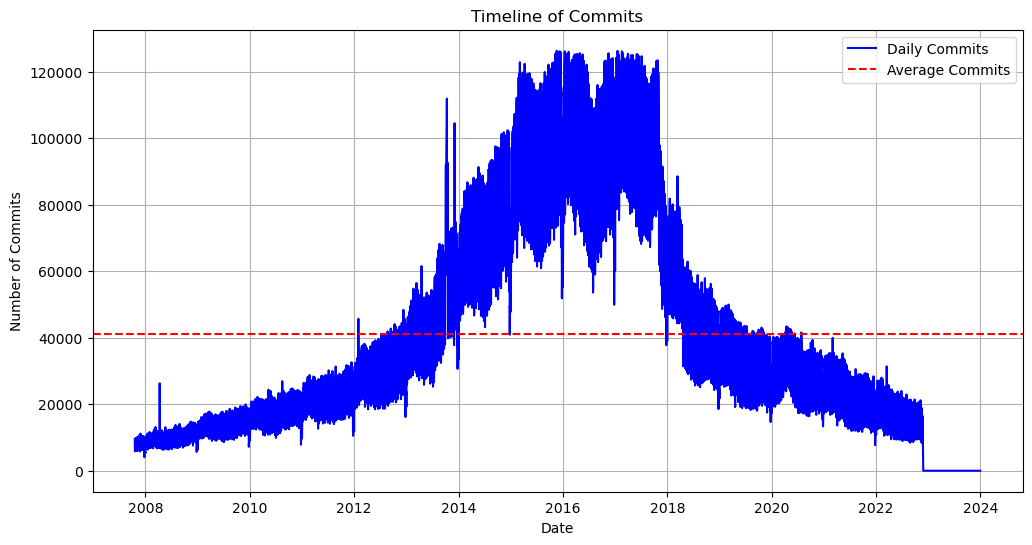

In [18]:
timeline_pd = filtered_timeline_agg.toPandas()


import matplotlib.pyplot as plt

# Plot the timeline
plt.figure(figsize=(12, 6))
plt.plot(timeline_pd["author_date"], timeline_pd["count"], label="Daily Commits", color="blue")
plt.title("Timeline of Commits")
plt.xlabel("Date")
plt.ylabel("Number of Commits")
plt.axhline(timeline_pd["count"].mean(), color="red", linestyle="--", label="Average Commits")
plt.legend()
plt.grid()
plt.show()


In [19]:
#Do you see any data collection gaps?

from pyspark.sql.functions import col, explode, sequence, lit

# Find the min and max date in the dataset
date_range = commits_cleaned_filtered.select(
    F.min("author_date").alias("min_date"),
    F.max("author_date").alias("max_date")
).collect()

start_date = date_range[0]["min_date"]
end_date = date_range[0]["max_date"]

# Generate a full sequence of dates
date_sequence = spark.sql(f"SELECT sequence(to_date('{start_date}'), to_date('{end_date}'), interval 1 day) as all_dates")
full_date_range = date_sequence.withColumn("author_date", explode(col("all_dates"))).select("author_date")


# Identify missing dates
missing_dates = full_date_range.join(commits_cleaned_filtered, "author_date", "left_anti")

In [14]:
print(f"number of missing date is {missing_dates.count()}")

number of missing date is 0


In [30]:
from pyspark.sql.window import Window

daily_commits = filtered_timeline_agg
#daily_commits.show()

In [31]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define a sliding window of 7 days
window_spec = Window.orderBy("author_date").rowsBetween(-6, 0)

# Add columns for moving average and standard deviation with proper names
daily_commits = daily_commits.withColumn(
    "moving_avg", F.avg("count").over(window_spec)
).withColumn(
    "moving_std", F.stddev("count").over(window_spec)
)


In [32]:
# Add flags for peaks and valleys
daily_commits = daily_commits.withColumn(
    "is_valley",
    F.when(
        F.col("count") < F.col("moving_avg") - 1.5 * F.col("moving_std"), True
    ).otherwise(False)
).withColumn(
    "is_peak",
    F.when(
        F.col("count") > F.col("moving_avg") + 1.5 * F.col("moving_std"), True
    ).otherwise(False)
)

# Show results
daily_commits.select("author_date", "count", "moving_avg", "moving_std", "is_valley", "is_peak").show(10)


24/12/11 17:59:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 17:59:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 17:59:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 17:59:55 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 17:59:55 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

+-----------+-----+-----------------+------------------+---------+-------+
|author_date|count|       moving_avg|        moving_std|is_valley|is_peak|
+-----------+-----+-----------------+------------------+---------+-------+
| 2007-10-19| 9377|           9377.0|              null|    false|  false|
| 2007-10-20| 5812|           7594.5| 2520.835674930042|    false|  false|
| 2007-10-21| 6288|           7159.0|1935.5327432001764|    false|  false|
| 2007-10-22| 9604|          7770.25|1998.0067358912147|    false|  false|
| 2007-10-23| 9773|           8170.8|1948.3902843116418|    false|  false|
| 2007-10-24| 9540|           8399.0|1830.1451308571131|    false|  false|
| 2007-10-25| 9098|8498.857142857143| 1691.446957348592|    false|  false|
| 2007-10-26| 9163|8468.285714285714|1674.7818479119117|    false|  false|
| 2007-10-27| 5936|           8486.0|1642.3451728143712|     true|  false|
| 2007-10-28| 6040| 8450.57142857143| 1699.348488602113|    false|  false|
+-----------+-----+------

24/12/11 18:01:32 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:01:32 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:01:32 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:03:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:03:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

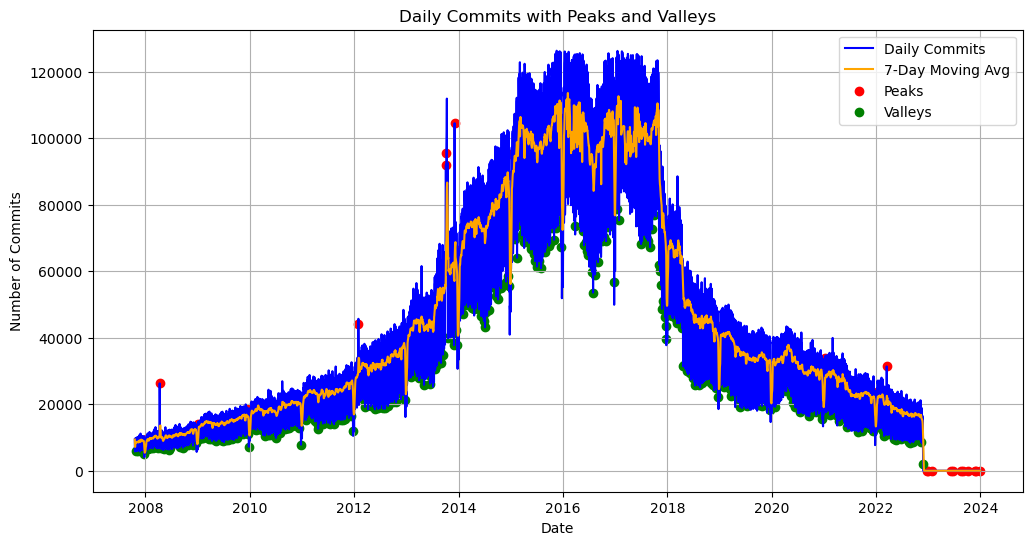

In [33]:
# Convert to Pandas
daily_commits_pd = daily_commits.toPandas()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_commits_pd["author_date"], daily_commits_pd["count"], label="Daily Commits", color="blue")
plt.plot(daily_commits_pd["author_date"], daily_commits_pd["moving_avg"], label="7-Day Moving Avg", color="orange")
plt.scatter(
    daily_commits_pd["author_date"][daily_commits_pd["is_peak"]],
    daily_commits_pd["count"][daily_commits_pd["is_peak"]],
    color="red", label="Peaks"
)
plt.scatter(
    daily_commits_pd["author_date"][daily_commits_pd["is_valley"]],
    daily_commits_pd["count"][daily_commits_pd["is_valley"]],
    color="green", label="Valleys"
)
plt.title("Daily Commits with Peaks and Valleys")
plt.xlabel("Date")
plt.ylabel("Number of Commits")
plt.legend()
plt.grid()
plt.show()


In [34]:
#Do you see any outliers?  Remove obvious outliers before plotting the timeline
# Filter out rows flagged as peaks or valleys
filtered_commits = daily_commits.filter(
    ~F.col("is_peak") & ~F.col("is_valley")  # Exclude peaks and valleys
)

# Show the cleaned data
filtered_commits.select("author_date", "count", "moving_avg", "moving_std").show(10)


24/12/11 18:03:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:03:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:03:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:04:54 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/11 18:04:54 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

+-----------+-----+-----------------+------------------+
|author_date|count|       moving_avg|        moving_std|
+-----------+-----+-----------------+------------------+
| 2007-10-19| 9377|           9377.0|              null|
| 2007-10-20| 5812|           7594.5| 2520.835674930042|
| 2007-10-21| 6288|           7159.0|1935.5327432001764|
| 2007-10-22| 9604|          7770.25|1998.0067358912147|
| 2007-10-23| 9773|           8170.8|1948.3902843116418|
| 2007-10-24| 9540|           8399.0|1830.1451308571131|
| 2007-10-25| 9098|8498.857142857143| 1691.446957348592|
| 2007-10-26| 9163|8468.285714285714|1674.7818479119117|
| 2007-10-28| 6040| 8450.57142857143| 1699.348488602113|
| 2007-10-29| 9393| 8420.42857142857| 1677.206293924797|
+-----------+-----+-----------------+------------------+
only showing top 10 rows



Do you see any spikes?  Are these spikes caused by real activities / events?
I see some spikes down at the end of each year, this could be caused by holiday season.

# What are the most popular programming languages on GitHub?
Did the trend of most popular programming languages change over time?

In [7]:
languages_df.show()

+--------------------+------------+
|           repo_name|    language|
+--------------------+------------+
|   lemi136/puntovent|   [{C, 80}]|
|      taxigps/nctool| [{C, 4461}]|
|         ahy1/strbuf| [{C, 5573}]|
| nleiten/mod_rpaf-ng|[{C, 30330}]|
| kmcallister/alameda|[{C, 17077}]|
|       TianYJ1/Snake|[{C, 10381}]|
|      doctorfree/Lds|[{C, 56413}]|
|SumiMakito/ReinaJ...| [{C, 7444}]|
|    serprex/rainbeam| [{C, 1964}]|
|   pdigiglio/oracolo| [{C, 1966}]|
|         jrb/vtclock|[{C, 23053}]|
|AhmedZanam/logica...| [{C, 1466}]|
|        ilardm/tsync|[{C, 64229}]|
|         lxzhu/runos|[{C, 21102}]|
|phillipgreenii/ir...| [{C, 3034}]|
|themaddoctor1/Mul...| [{C, 7774}]|
|Mr-Kumar-Abhishek...|  [{C, 233}]|
|tidatida/Small-Op...| [{C, 1664}]|
|magnusviri/matrix...|[{C, 93643}]|
|Atalanta/run-leng...|  [{C, 756}]|
+--------------------+------------+
only showing top 20 rows



In [21]:
languages_df.printSchema()
commits_cleaned_filtered.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author_date: date (nullable = true)



In [28]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!

# Flatten the array column
flattened_df = languages_df.withColumn("language", explode(F.col("language")))

# Extract relevant fields
flattened_df = flattened_df.select(
    F.col("repo_name"),
    F.col("language.name").alias("language_name"),
    F.col("language.bytes").alias("bytes")
)

# Show the flattened DataFrame
flattened_df.show(10)

+--------------------+-------------+-----+
|           repo_name|language_name|bytes|
+--------------------+-------------+-----+
|   lemi136/puntovent|            C|   80|
|      taxigps/nctool|            C| 4461|
|         ahy1/strbuf|            C| 5573|
| nleiten/mod_rpaf-ng|            C|30330|
| kmcallister/alameda|            C|17077|
|       TianYJ1/Snake|            C|10381|
|      doctorfree/Lds|            C|56413|
|SumiMakito/ReinaJ...|            C| 7444|
|    serprex/rainbeam|            C| 1964|
|   pdigiglio/oracolo|            C| 1966|
+--------------------+-------------+-----+
only showing top 10 rows



In [23]:
repo_language_count = flattened_df.groupBy("repo_name").agg(
    F.countDistinct("language_name").alias("language_count")
)

# Show repositories with multiple languages
multi_language_repos = repo_language_count.filter(col("language_count") > 1)

# Show the result
multi_language_repos.show(10)

+--------------------+--------------+
|           repo_name|language_count|
+--------------------+--------------+
|npmcomponent/timo...|             6|
|        jof/shotwell|             4|
|MoKee/android_ker...|            15|
|        rcsole/Atena|             2|
|        Mehuge/cu-ui|             4|
|  nattomi/TLEbrowser|             4|
|     bappelt/listify|             3|
|hbbtstar/analytic...|             3|
|    asterIRC/PitIRCd|             7|
|openxc/OpenXCAcce...|             3|
+--------------------+--------------+
only showing top 10 rows



In [24]:
# Join with the original flattened DataFrame
multi_language_repo_details = multi_language_repos.join(
    flattened_df, "repo_name", "inner"
)

# Show the result
multi_language_repo_details.show()


+--------------------+--------------+-------------+-------+
|           repo_name|language_count|language_name|  bytes|
+--------------------+--------------+-------------+-------+
|    001szymon/uBlock|             4|          CSS|  45547|
|    001szymon/uBlock|             4|         HTML|  30927|
|    001szymon/uBlock|             4|   JavaScript|1063176|
|    001szymon/uBlock|             4|        Shell|   3138|
|00krishna-tools/p...|             3|     Makefile|   2264|
|00krishna-tools/p...|             3|       Python|  65104|
|00krishna-tools/p...|             3|        Shell|    326|
|0110/WookieContro...|             3|            C|  68312|
|0110/WookieContro...|             3|     Makefile|   7025|
|0110/WookieContro...|             3|        Shell|    126|
|   01org/toucheffect|             2|          C++|  58828|
|   01org/toucheffect|             2|         Perl|   6864|
|01org/webapps-rabbit|             4|          CSS|  17710|
|01org/webapps-rabbit|             4|   

### Popularity measured by -- Bytes (code size)

In [10]:
language_popularity_bytes = flattened_df.groupBy("language_name").agg(\
                            F.sum("bytes").alias("total_bytes")\
                            ).orderBy(F.desc("total_bytes"))

language_popularity_bytes.show()

+--------------------+-------------+
|       language_name|  total_bytes|
+--------------------+-------------+
|                   C|5931025072304|
|          JavaScript|1239727221800|
|                 C++| 516119676699|
|                 PHP| 505682751567|
|                HTML| 352213745022|
|                Java| 307317945889|
|              Python| 189352151881|
|                 CSS| 151064182371|
|            Assembly| 130370626871|
|                  C#| 127064567239|
|                  Go|  69071955729|
|    Jupyter Notebook|  67407267359|
|         Objective-C|  58347435199|
|                Ruby|  37790798240|
|          TypeScript|  34406949807|
|               Shell|  31047657667|
|                Perl|  29910210552|
|            Makefile|  23302876334|
|Web Ontology Lang...|  12767299264|
|        Visual Basic|  12271099727|
+--------------------+-------------+
only showing top 20 rows



### Popularity measured by -- Number of repository

In [26]:
# Count unique repositories by language
language_popularity_repos = flattened_df.groupBy("language_name").agg(
    F.countDistinct("repo_name").alias("repo_count")
).orderBy(F.desc("repo_count"))

# Show most popular languages by repository count
language_popularity_repos.show()


+-------------+----------+
|language_name|repo_count|
+-------------+----------+
|   JavaScript|   1099966|
|          CSS|    807826|
|         HTML|    777433|
|        Shell|    640886|
|       Python|    550905|
|         Ruby|    374276|
|         Java|    369673|
|          PHP|    339426|
|            C|    293231|
|          C++|    277871|
|     Makefile|    251366|
|  Objective-C|    166961|
|           C#|    133110|
|         Perl|    101533|
|    Batchfile|     97868|
|           Go|     91867|
| CoffeeScript|     68589|
|   ApacheConf|     68500|
|        CMake|     56754|
|   TypeScript|     48027|
+-------------+----------+
only showing top 20 rows



In [43]:
languages_df.printSchema()
flattened_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [12]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!
commits_exploded = commits_cleaned_filtered.withColumn("repo_name", F.explode(F.col("repo_name")))

joined_df = commits_exploded.join(flattened_df, on="repo_name", how="inner")
#joined_df.show()

In [13]:
joined_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- author_date: date (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [ ]:
from pyspark.sql.functions import year, sum as _sum, col

# Extract year from `author_date`
trends_df = joined_df.withColumn("year", year(col("author_date")))

# Aggregate data by year and language
language_trends = trends_df.groupBy("year", "language_name").agg(
    _sum("bytes").alias("total_bytes")
).orderBy("year", col("total_bytes").desc())

# Show the aggregated trends
language_trends.show()


+----+-------------+-----------------+
|year|language_name|      total_bytes|
+----+-------------+-----------------+
|2007|            C|18508367872193411|
|2007|     Assembly|  376454601732089|
|2007|          C++|  257743156222903|
|2007|  Objective-C|   56926637375789|
|2007|     Makefile|   39873264626767|
|2007|         Java|   33817118978102|
|2007|          PHP|   33153810691201|
|2007|         Perl|   21591345963409|
|2007|       Python|   13224856788673|
|2007|   JavaScript|   10180669917482|
|2007|        Shell|    9387912053817|
|2007|   Emacs Lisp|    8140728585673|
|2007|         HTML|    5310519673574|
|2007|          Ada|    4595540055124|
|2007|            D|    2679158535774|
|2007|         Yacc|    2084038661876|
|2007|        Groff|    1555362625251|
|2007|          CSS|    1532927262068|
|2007|           Go|    1384357334085|
|2007|         Ruby|    1067882289066|
+----+-------------+-----------------+
only showing top 20 rows



In [ ]:
language_trends.printSchema()

root
 |-- year: integer (nullable = true)
 |-- language_name: string (nullable = true)
 |-- total_bytes: long (nullable = true)



In [17]:
print("h")

h


In [18]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# Define a window partitioned by year and ordered by total_bytes in descending order
window_spec = Window.partitionBy("year").orderBy(col("total_bytes").desc())

# Add a row number column to rank languages within each year
ranked_df = language_trends.withColumn("rank", row_number().over(window_spec))

# Filter to get only the top 5 languages for each year
top_5_languages = ranked_df.filter(col("rank") <= 5).orderBy("year", col("rank"))

# Show the results
top_5_languages.show()


+----+-------------+------------------+----+
|year|language_name|       total_bytes|rank|
+----+-------------+------------------+----+
|2007|            C| 18508367872193411|   1|
|2007|     Assembly|   376454601732089|   2|
|2007|          C++|   257743156222903|   3|
|2007|  Objective-C|    56926637375789|   4|
|2007|     Makefile|    39873264626767|   5|
|2008|            C|124039768614138099|   1|
|2008|     Assembly|  2518141976343575|   2|
|2008|          C++|  1709964288117696|   3|
|2008|  Objective-C|   381424076839601|   4|
|2008|     Makefile|   264440792305474|   5|
|2009|            C|132882095997635436|   1|
|2009|     Assembly|  2700120392147857|   2|
|2009|          C++|  2004822909236523|   3|
|2009|  Objective-C|   412634470216877|   4|
|2009|     Makefile|   284196425169527|   5|
|2010|            C|123926176939635276|   1|
|2010|     Assembly|  2518507753042944|   2|
|2010|          C++|  2017565544837073|   3|
|2010|  Objective-C|   387968567043323|   4|
|2010|    

In [19]:
# Convert to Pandas DataFrame for visualization
top_5_languages_pd = top_5_languages.toPandas()

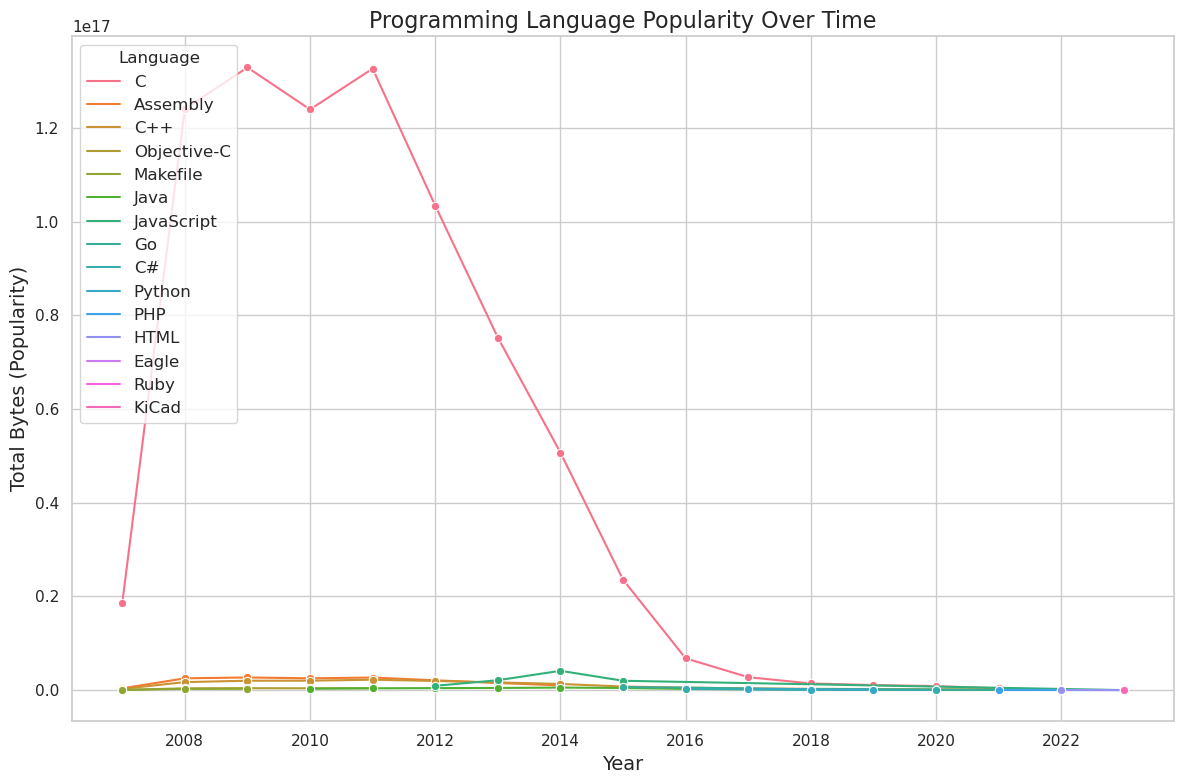

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for the plot
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=top_5_languages_pd,
    x="year",
    y="total_bytes",
    hue="language_name",
    marker="o"
)

# Customize the plot
plt.title("Programming Language Popularity Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Bytes (Popularity)", fontsize=14)
plt.legend(title="Language", loc="upper left", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


# what is the distribution of licenses across github repo
#### Any certain programming languages that are more likely to be associated with a particular license?

In [ ]:
licenses_df.printSchema()
languages_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



In [29]:
#runnnnnnnnnn!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!nnnnnnnnnn!!!!!!!!!!!!!!!!!!!!!!
joined_df1 = licenses_df.join(flattened_df, on="repo_name", how="inner")

In [ ]:
joined_df1.show()

+--------------------+----------+-------------+-------+
|           repo_name|   license|language_name|  bytes|
+--------------------+----------+-------------+-------+
|        0-0-1/cogbot|       mit|       Python|  40997|
|0-Eclipse-0/SaltB...|   gpl-2.0|    Batchfile|     78|
|    001szymon/uBlock|   gpl-3.0|          CSS|  45547|
|    001szymon/uBlock|   gpl-3.0|         HTML|  30927|
|    001szymon/uBlock|   gpl-3.0|   JavaScript|1063176|
|    001szymon/uBlock|   gpl-3.0|        Shell|   3138|
|008v/AppStore-Scr...|   gpl-3.0|        Shell|   1903|
|00SteinsGate00/ba...|       mit|       Python|   5884|
|00krishna-tools/p...|       mit|     Makefile|   2264|
|00krishna-tools/p...|       mit|       Python|  65104|
|00krishna-tools/p...|       mit|        Shell|    326|
|0110/WookieContro...|       mit|            C|  68312|
|0110/WookieContro...|       mit|     Makefile|   7025|
|0110/WookieContro...|       mit|        Shell|    126|
|0111001101111010/...|       mit|          CSS| 

In [ ]:
joined_df1.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [ ]:
license_distribution = joined_df1.groupBy("license").agg(
    F.count("repo_name").alias("repo_count")
).orderBy("repo_count", ascending=False)

license_distribution.show(10)

+------------+----------+
|     license|repo_count|
+------------+----------+
|         mit|   3603080|
|  apache-2.0|   1180687|
|     gpl-2.0|   1089260|
|     gpl-3.0|    834322|
|bsd-3-clause|    437805|
|    agpl-3.0|    131955|
|bsd-2-clause|    130130|
|    lgpl-3.0|     95599|
|    lgpl-2.1|     84686|
|   unlicense|     71607|
+------------+----------+
only showing top 10 rows



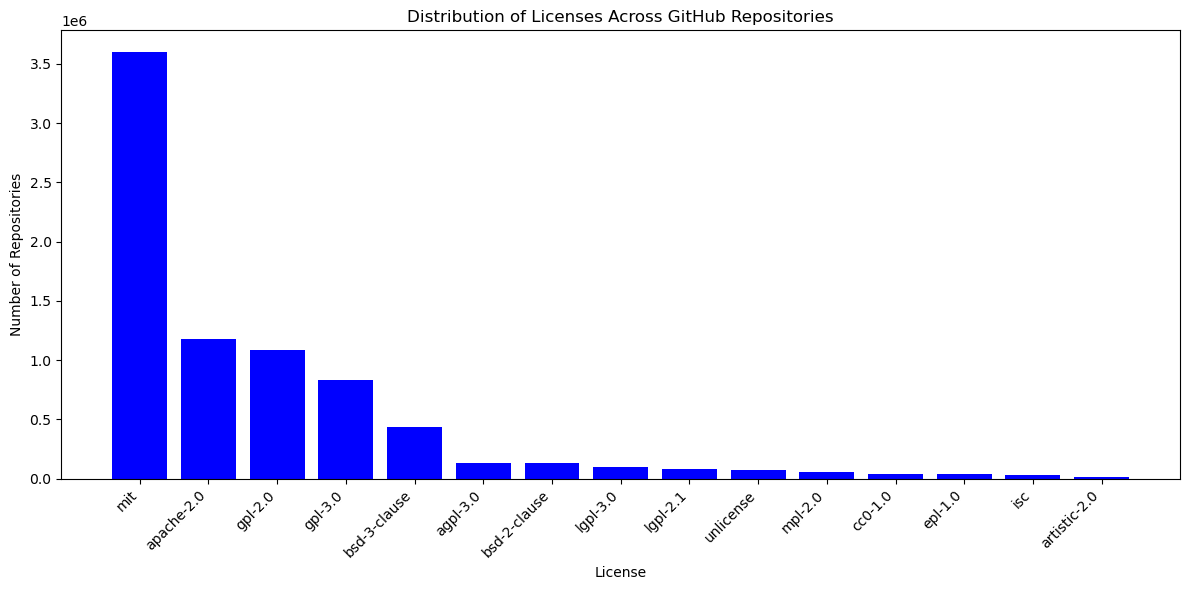

In [ ]:
import matplotlib.pyplot as plt

license_distribution_pd = license_distribution.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(license_distribution_pd["license"], license_distribution_pd["repo_count"], color="blue")
plt.title("Distribution of Licenses Across GitHub Repositories")
plt.xlabel("License")
plt.ylabel("Number of Repositories")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
flattened_df.printSchema()
joined_df1.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [ ]:
language_license_stats = joined_df1.groupBy("license", "language_name").agg(
    _sum("bytes").alias("total_bytes")
).orderBy("license", col("total_bytes").desc())

language_license_stats.show()

+--------+----------------+-----------+
| license|   language_name|total_bytes|
+--------+----------------+-----------+
|agpl-3.0|      JavaScript|15794439063|
|agpl-3.0|          Python|13947621322|
|agpl-3.0|             PHP|13588429815|
|agpl-3.0|            Java| 9069228035|
|agpl-3.0|            HTML| 7554705783|
|agpl-3.0|             C++| 5751133734|
|agpl-3.0|               C| 3907708584|
|agpl-3.0|              DM| 3622970504|
|agpl-3.0|             CSS| 2888001637|
|agpl-3.0|            Ruby| 2288620396|
|agpl-3.0|            Perl| 1530883080|
|agpl-3.0|              Go| 1029848879|
|agpl-3.0|Jupyter Notebook|  847658519|
|agpl-3.0|              C#|  672460439|
|agpl-3.0|    CoffeeScript|  544906857|
|agpl-3.0|           PLSQL|  468656318|
|agpl-3.0|             Lua|  413882838|
|agpl-3.0|          Smarty|  369882600|
|agpl-3.0|      TypeScript|  346205394|
|agpl-3.0| Gettext Catalog|  292231695|
+--------+----------------+-----------+
only showing top 20 rows



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("license").orderBy(col("total_bytes").desc())

ranked_languages = language_license_stats.withColumn("rank", row_number().over(window_spec))

# Filter top languages for each license
top_languages_per_license = ranked_languages.filter(col("rank") == 1)

# Show the most associated language for each license
top_languages_per_license.show()


+------------+--------------------+-------------+----+
|     license|       language_name|  total_bytes|rank|
+------------+--------------------+-------------+----+
|   unlicense|                HTML|   2080117740|   1|
|    lgpl-3.0|                   C|   8889892991|   1|
|     cc0-1.0|Web Ontology Lang...|   9420474028|   1|
|     gpl-2.0|                   C|5610511330580|   1|
|bsd-3-clause|                 C++|  81918698684|   1|
|     epl-1.0|                Java|  10582155526|   1|
|     gpl-3.0|                   C| 107082788787|   1|
|bsd-2-clause|                   C|   8786058514|   1|
|  apache-2.0|                Java| 179468234800|   1|
|     mpl-2.0|                HTML|   3963026750|   1|
|         isc|                   C|   1060899447|   1|
|artistic-2.0|          JavaScript|    707447550|   1|
|    agpl-3.0|          JavaScript|  15794439063|   1|
|         mit|          JavaScript| 978966251480|   1|
|    lgpl-2.1|                 C++|  26263653371|   1|
+---------

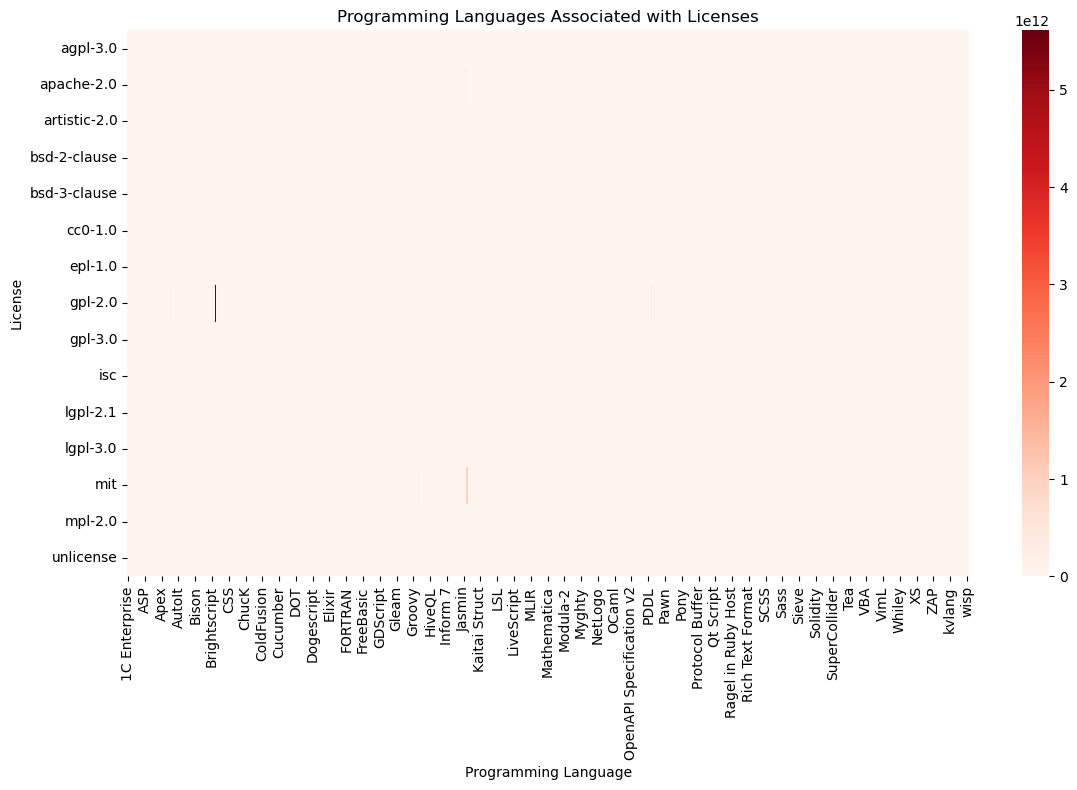

In [ ]:
import seaborn as sns
import pandas as pd

# Convert to Pandas
heatmap_data = language_license_stats.toPandas()

# Pivot data for a heatmap
heatmap_pivot = heatmap_data.pivot(index="license", columns="language_name", values="total_bytes").fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap="Reds", annot=False, cbar=True)
plt.title("Programming Languages Associated with Licenses")
plt.xlabel("Programming Language")
plt.ylabel("License")
plt.tight_layout()
plt.show()


# What can you tell about the most popular and most rapidly growing repositories?
### Is there certain technology that is driving popularity or explosive growth?
### Are these associated with Big TechLinks to an external site., who are open sourcing the technology?
### Are there any technological breakthroughs that are driving this brisk adoption?

In [30]:
commits_cleaned_filtered.printSchema()
commits_exploded.printSchema()
joined_df1.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author_date: date (nullable = true)

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo_name: string (nullable = true)
 |-- author_date: date (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [ ]:
import pyspark.sql.functions as F


In [ ]:
most_popular = joined_df1.groupBy("repo_name").agg(F.sum("bytes").alias("total_bytes")).orderBy(F.col("total_bytes").desc())

most_popular.show(5)

+-------------------+-----------+
|          repo_name|total_bytes|
+-------------------+-----------+
|    aashish24/cdnjs| 5580890143|
|mgoldsborough/cdnjs| 5579157705|
|      stdlib-js/www| 5554088641|
|   nareshs435/cdnjs| 5538002104|
|        dhowe/cdnjs| 5521841528|
+-------------------+-----------+
only showing top 5 rows



In [31]:
temp = commits_exploded.select("author_date", "repo_name")
temp1 = temp.join(joined_df1, on="repo_name", how="inner")

temp1.show()

+------------+-----------+-------+-------------+-----+
|   repo_name|author_date|license|language_name|bytes|
+------------+-----------+-------+-------------+-----+
|0-0-1/cogbot| 2017-08-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-02-04|    mit|       Python|40997|
|0-0-1/cogbot| 2017-08-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-05-06|    mit|       Python|40997|
|0-0-1/cogbot| 2017-05-16|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-27|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-19|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-15|    mit|       Python|40997|
|0-0-1/cogbot| 2017-01-21|    mit|       Python|40997|
|0-0-1/cogbot| 2017-05-06|    mit|       Python|40997|
|0-0-1/cogbot| 2017-08-19|    mit|       Python|40997|
|0-0-1/cog

In [35]:
# Add 'year' column extracted from 'author_date'
temp1 = temp1.withColumn("year", F.year(F.col("author_date")))

# Perform groupBy and aggregate bytes for each repo_name and year
temp1 = temp1.groupBy("repo_name", "year").agg(F.sum(F.col("bytes")).alias("total_yearly_bytes"))

# Define a window specification for calculating lag
window_spec = Window.partitionBy("repo_name").orderBy("year")

repo_yearly_bytes = temp1.withColumn("prev_year_bytes", F.lag("total_yearly_bytes").over(window_spec)). \
    withColumn("growth", F.col("total_yearly_bytes") - F.col("prev_year_bytes"))


In [ ]:
rapid_growth_repo = repo_yearly_bytes.groupBy("repo_name").\
                        agg(F.max("growth").alias("max_growth")).orderBy(F.col("max_growth").desc())

rapid_growth_repo.show(10)

+--------------------+--------------+
|           repo_name|    max_growth|
+--------------------+--------------+
|dperezde/little-p...|39574885091040|
|      zhiyisun/linux|30119615920065|
|    HarveyHunt/linux|30116595516210|
|         elp/iwlwifi|29719397850576|
|      sunny256/linux|29694985884945|
|        hannes/linux|29693850495405|
|          djbw/linux|29691488896800|
|        oldzhu/linux|29557106009730|
|tescande/linux-nf...|29418462793290|
|Broadcom/cygnus-l...|29417129180265|
+--------------------+--------------+
only showing top 10 rows



In [ ]:
contents_df.printSchema()
files_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- size: long (nullable = true)
 |-- content: string (nullable = true)
 |-- binary: boolean (nullable = true)
 |-- copies: long (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- ref: string (nullable = true)
 |-- path: string (nullable = true)
 |-- mode: long (nullable = true)
 |-- id: string (nullable = true)
 |-- symlink_target: string (nullable = true)



In [41]:
from pyspark.sql.functions import col, lower, lit, count

# Define keywords for neural network and generative AI technologies
keywords = ["pytorch", "transformers", "openai"]

# Filter commits mentioning these technologies in `subject` or `message`
technology_commits = None

sampled_df = commits_cleaned_filtered.sample(withReplacement=False, fraction=0.01, seed=40)


# Loop through keywords to extract data for each technology
for keyword in keywords:
    filtered_df = sampled_df \
        .filter(
            (lower(col("subject")).contains(keyword)) |
            (lower(col("message")).contains(keyword))
        ) \
        .withColumn("technology", lit(keyword))
    
    if technology_commits is None:
        technology_commits = filtered_df
    else:
        technology_commits = technology_commits.union(filtered_df)

# Count occurrences for each technology
technology_counts = technology_commits \
    .groupBy("technology") \
    .agg(count("*").alias("count"))

# Show results
technology_counts.show()


+------------+-----+
|  technology|count|
+------------+-----+
|     pytorch|  153|
|      openai|   58|
|transformers|  155|
+------------+-----+



In [38]:
joined_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- author_date: date (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [44]:
from pyspark.sql.functions import to_date, col

# Ensure `author_date` is in DateType
technology_commits = technology_commits.withColumn("author_date", to_date(col("author_date")))


In [45]:
from pyspark.sql.functions import year

# Add a 'year' column based on `author_date`
technology_commits = technology_commits.withColumn("year", year(col("author_date")))


In [46]:
from pyspark.sql.functions import count

# Count occurrences for each technology per year
technology_yearly_counts = technology_commits \
    .groupBy("technology", "year") \
    .agg(count("*").alias("frequency")) \
    .orderBy("technology", "year")


In [47]:
# Show the results
technology_yearly_counts.show(truncate=False)


+----------+----+---------+
|technology|year|frequency|
+----------+----+---------+
|openai    |2007|1        |
|openai    |2008|1        |
|openai    |2009|2        |
|openai    |2010|4        |
|openai    |2011|2        |
|openai    |2012|6        |
|openai    |2013|8        |
|openai    |2014|11       |
|openai    |2015|3        |
|openai    |2016|4        |
|openai    |2017|5        |
|openai    |2018|2        |
|openai    |2019|1        |
|openai    |2020|4        |
|openai    |2021|1        |
|openai    |2022|3        |
|pytorch   |2017|17       |
|pytorch   |2018|22       |
|pytorch   |2019|23       |
|pytorch   |2020|29       |
+----------+----+---------+
only showing top 20 rows



In [ ]:
big_tech_domains = ["google", "microsoft", "openai", "apple"]
big_tech_keywords = ["tensorflow", "pytorch", "transformers"]


In [ ]:
from pyspark.sql.functions import col, lower, lit, when, explode

# Explode the `repo_name` array into individual rows
technology_commits_exploded = technology_commits.withColumn("repo_name_exploded", explode(col("repo_name")))

# Define Big Tech domains
big_tech_domains = ["google", "microsoft", "amazon", "meta", "openai", "apple", "facebook"]

# Filter for repositories associated with Big Tech based on repo_name or email
big_tech_commits = technology_commits_exploded.filter(
    (lower(col("repo_name_exploded")).rlike("|".join(big_tech_domains))) |
    (lower(col("email")).rlike("|".join(big_tech_domains)))
)

# Tag rows with the associated Big Tech company
big_tech_commits = big_tech_commits.withColumn(
    "big_tech_association",
    when(lower(col("repo_name_exploded")).contains("google"), "Google")
    .when(lower(col("repo_name_exploded")).contains("microsoft"), "Microsoft")
    .when(lower(col("repo_name_exploded")).contains("amazon"), "Amazon")
    .when(lower(col("repo_name_exploded")).contains("openai"), "OpenAI")
    .when(lower(col("repo_name_exploded")).contains("meta"), "Meta")
    .when(lower(col("repo_name_exploded")).contains("apple"), "Apple")
    .otherwise("Unknown")
)

# Count commits by Big Tech association
big_tech_counts = big_tech_commits.groupBy("big_tech_association").count()

# Show results
big_tech_counts.show()


+--------------------+-----+
|big_tech_association|count|
+--------------------+-----+
|             Unknown|   66|
|                Meta|    2|
|              Google|    2|
|           Microsoft|    2|
|               Apple|    1|
|              OpenAI|   61|
+--------------------+-----+



# What are the most frequent reasons for committing into GitHub repositories?
### Is this new technology development, bug fix, etc.

In [41]:
reason_count = commits_exploded.groupBy("subject").count().orderBy(F.col("count").desc())
reason_count = reason_count.dropna()

+-----------------------------------------------------------------------------------------------------+-------+
|subject                                                                                              |count  |
+-----------------------------------------------------------------------------------------------------+-------+
|Update README.md                                                                                     |5243487|
|                                                                                                     |3681681|
|Translation update done using Pootle.                                                                |2670842|
|Initial commit                                                                                       |2250000|
|drew a picture :art:                                                                                 |1619859|
|Merge git://git.kernel.org/pub/scm/linux/kernel/git/davem/net-2.6                                    |1

In [42]:
reason_count.show(20, truncate=False)

+-----------------------------------------------------------------------------------------------------+-------+
|subject                                                                                              |count  |
+-----------------------------------------------------------------------------------------------------+-------+
|Update README.md                                                                                     |5243487|
|                                                                                                     |3681681|
|Translation update done using Pootle.                                                                |2670842|
|Initial commit                                                                                       |2250000|
|drew a picture :art:                                                                                 |1619859|
|Merge git://git.kernel.org/pub/scm/linux/kernel/git/davem/net-2.6                                    |1

In [ ]:
commits_exploded.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo_name: string (nullable = true)
 |-- author_date: date (nullable = true)



# Identify the most prolific / influential Committers
### By commit volume
### Visualize the distribution of these commits

In [ ]:
joined_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- author_date: date (nullable = true)
 |-- language_name: string (nullable = true)
 |-- bytes: long (nullable = true)



In [ ]:
# Group by 'name' and calculate the sum of 'bytes'
prolific_author = joined_df.groupBy("name").agg(F.sum("bytes").alias("commit_amount"))\
        .orderBy(F.col("commit_amount").desc())

# Show the result
prolific_author.show()


+--------------------+-----------------+
|                name|    commit_amount|
+--------------------+-----------------+
|      Linus Torvalds|29109916116651466|
|Linux Build Servi...|13376629602166013|
|          Mark Brown| 9536242517241886|
|     David S. Miller| 9327534061734626|
|        Takashi Iwai| 8340312503545829|
|         Ingo Molnar| 8221318093136061|
|             Al Viro| 6227923722353981|
|       Johannes Berg| 6164230732066701|
|  Greg Kroah-Hartman| 5835670845979057|
|Mauro Carvalho Ch...| 5658677437444163|
|        Russell King| 5532868944732502|
|           Tejun Heo| 5110559461283080|
|          Paul Mundt| 4996757856109299|
|   H Hartley Sweeten| 4952063012022040|
|Bartlomiej Zolnie...| 4891953457304023|
|     Thomas Gleixner| 4799830551597446|
|         Joe Perches| 4788111438856497|
|        Eric Dumazet| 4150217953341934|
|        Hans Verkuil| 4042872535123890|
|            Axel Lin| 3674923047496373|
+--------------------+-----------------+
only showing top

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


prolific_author_pd = prolific_author.toPandas()

# Plot the distribution of commits
plt.figure(figsize=(10, 6))
plt.bar(prolific_author_pd['name'], prolific_author_pd['commit_amount'], color='skyblue')

# Customize the plot
plt.title("Distribution of Commits by Author", fontsize=16)
plt.xlabel("Author Name", fontsize=12)
plt.ylabel("Commit Amount (Bytes)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
commits_exploded.printShema()

# How unique are the “subject” and “message” values?
### Are they mostly unique? Or are people usually just copy-pasting the same text?
### You can use LSH to measure uniqueness / similarity
### Visualize “subject” and “message” duplication across all programming languages
### Visualize “subject” and “message” duplication for each of the top 5 programming languages
### Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [8]:
# Calculate total number of rows
total_rows = commits_exploded.count()

# Calculate distinct counts for 'subject' and 'message'
distinct_subject_count = commits_exploded.select("subject").distinct().count()
distinct_message_count = commits_exploded.select("message").distinct().count()

# Calculate uniqueness ratios
subject_uniqueness_ratio = distinct_subject_count / total_rows
message_uniqueness_ratio = distinct_message_count / total_rows

# Display the results
print(f"Total Rows: {total_rows}")
print(f"Distinct Subjects: {distinct_subject_count}")
print(f"Distinct Messages: {distinct_message_count}")
print(f"Subject Uniqueness Ratio: {subject_uniqueness_ratio:.2%}")
print(f"Message Uniqueness Ratio: {message_uniqueness_ratio:.2%}")


Total Rows: 3218419786
Distinct Subjects: 169309119
Distinct Messages: 179875673
Subject Uniqueness Ratio: 5.26%
Message Uniqueness Ratio: 5.59%


In [58]:
commits_exploded.printSchema()
languages_df.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- author_date_seconds: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo_name: string (nullable = true)
 |-- author_date: date (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



In [63]:
languages_exploded = languages_df.withColumn("language_name", F.explode(F.col("language.name")))

In [49]:
languages_exploded.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)
 |-- language_name: string (nullable = true)



In [64]:
from pyspark.sql import functions as F

# Apply the filter correctly
filtered_languages = languages_exploded.filter(
    F.col("repo_name").isNotNull() | F.col("language_name").isNotNull()


SyntaxError: unexpected EOF while parsing (1813628700.py, line 5)

In [50]:


# Display the first 10 rows
filtered_languages.limit(10).show()


+--------------------+------------+-------------+
|           repo_name|    language|language_name|
+--------------------+------------+-------------+
|   lemi136/puntovent|   [{C, 80}]|            C|
|      taxigps/nctool| [{C, 4461}]|            C|
|         ahy1/strbuf| [{C, 5573}]|            C|
| nleiten/mod_rpaf-ng|[{C, 30330}]|            C|
| kmcallister/alameda|[{C, 17077}]|            C|
|       TianYJ1/Snake|[{C, 10381}]|            C|
|      doctorfree/Lds|[{C, 56413}]|            C|
|SumiMakito/ReinaJ...| [{C, 7444}]|            C|
|    serprex/rainbeam| [{C, 1964}]|            C|
|   pdigiglio/oracolo| [{C, 1966}]|            C|
+--------------------+------------+-------------+



In [22]:
commits_exploded.show()

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-----------+
|              commit|                tree|                name|               email|author_date_seconds|             subject|             message|           repo_name|author_date|
+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-----------+
|aa358905a1b12c6fa...|df3f8bf61bf1cb0df...|conda-forge-coord...|e5ec32c8593b6ea32...|         1647357073|Updated the qceng...|Updated the qceng...|conda-forge/feeds...| 2022-03-15|
|5a6b6d6d29489f858...|ff89accb7e283ca88...|           Rob Allen|7e09c9d3e96378bf5...|         1323443117|Merge remote-trac...|Merge remote-trac...|MadCat34/zend-esc...| 2011-12-09|
|5a6b6d6d29489f858...|ff89accb7e283ca88...|           Rob Allen|7e09c9d3e96378bf5...|         1

In [65]:
from pyspark.sql.functions import udf, col


In [66]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType


In [67]:
tokenizer = Tokenizer(inputCol="subject", outputCol="tokens_df1")
tokenized_df = tokenizer.transform(commits_exploded)

tokenizer2 = Tokenizer(inputCol="message", outputCol="tokens_df2")
tokenized_df = tokenizer2.transform(tokenized_df)


In [68]:
hashing_tf1 = HashingTF(inputCol="tokens_df1", outputCol="features_df1", numFeatures=1000)
vectorized_df = hashing_tf1.transform(tokenized_df)

hashing_tf2 = HashingTF(inputCol="tokens_df2", outputCol="features_df2", numFeatures=1000)
vectorized_df = hashing_tf2.transform(vectorized_df)


In [69]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector

# Define cosine similarity function
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_v1 = float(v1.norm(2))
    norm_v2 = float(v2.norm(2))
    return dot_product / (norm_v1 * norm_v2) if norm_v1 != 0 and norm_v2 != 0 else 0.0

# UDF to compute cosine similarity
cosine_similarity_udf = udf(cosine_similarity, DoubleType())


In [70]:
# Add cosine similarity column
similarity_df = vectorized_df.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("features_df1"), col("features_df2"))
)

In [56]:
similarity_df.select("subject", "message", "cosine_similarity").show()

+--------------------+--------------------+------------------+
|             subject|             message| cosine_similarity|
+--------------------+--------------------+------------------+
|Updated the qceng...|Updated the qceng...|               1.0|
|Merge remote-trac...|Merge remote-trac...|               1.0|
|Merge remote-trac...|Merge remote-trac...|               1.0|
|Merge remote-trac...|Merge remote-trac...|               1.0|
|provide hook to o...|provide hook to o...|0.7977240352174656|
|provide hook to o...|provide hook to o...|0.7977240352174656|
|Updated the mailc...|Updated the mailc...|               1.0|
|    2014-03-06T04:30|   2014-03-06T04:30
|               1.0|
|Updated the kiwip...|Updated the kiwip...|               1.0|
|am a85facc6: am 8...|am a85facc6: am 8...|0.9545214042184236|
|Correct importing...|Correct importing...|0.3959797974644666|
|am 77f37918: (-s ...|am 77f37918: (-s ...|0.9495486515371063|
|                kréz|                kréz|            

In [71]:
similarity_df = similarity_df.filter(F.col("cosine_similarity") != 1.0)

In [72]:
similarity_df = similarity_df.select("repo_name", "subject", "message", "cosine_similarity")

In [73]:
similarity_df.printSchema()
filtered_languages.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- cosine_similarity: double (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)
 |-- language_name: string (nullable = true)



In [74]:
df1_alias = similarity_df.alias("df1")
df2_alias = filtered_languages.select("language_name", "repo_name").alias("df2")

result_df = df1_alias.join(df2_alias, df1_alias["repo_name"] == df2_alias["repo_name"], "inner")
result_df = result_df.select(
    col("df1.repo_name"),
    col("df1.subject").alias("df1_subject"),
    col("df1.message").alias("df1_message"),
    col("df2.language_name"),
    col("df1.cosine_similarity")
)

In [76]:
result_df.cache()

DataFrame[repo_name: string, df1_subject: string, df1_message: string, language_name: string, cosine_similarity: double]

In [75]:
result_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- df1_subject: string (nullable = true)
 |-- df1_message: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- cosine_similarity: double (nullable = true)



In [77]:
temp = result_df.groupBy("language_name") \
    .agg(F.avg("cosine_similarity").alias("lang_avg_sim"))

In [78]:
temp.cache()

DataFrame[language_name: string, lang_avg_sim: double]

In [79]:
temp.printSchema()

root
 |-- language_name: string (nullable = true)
 |-- lang_avg_sim: double (nullable = true)



In [80]:
sampled_temp = temp.sample(withReplacement=False, fraction=0.0001, seed=43)
#sampled_temp.show()

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas
lang_avg_sim_df = sampled_temp.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(lang_avg_sim_df['language'], lang_avg_sim_df['lang_avg_sim'], color='skyblue')
plt.xlabel('Programming Language')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity by Programming Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [83]:
top_languages = ["C", "JavaScript", "C++", "PHP", "HTML"]
filtered_temp = sampled_temp.filter(F.col("language_name").isin(top_languages))


In [84]:
# Convert to Pandas
filtered_lang_avg_sim_df = filtered_temp.toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(filtered_lang_avg_sim_df['language'], filtered_lang_avg_sim_df['lang_avg_sim'], color='skyblue')
plt.xlabel('Programming Language')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity for Top 5 Programming Languages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 